In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model

## Datos:

In [2]:
df = pd.read_csv('Boston.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = pd.get_dummies(df, columns = ['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,1,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,0,1,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,0,1,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,0,0,1,0,0,0,0,0,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,0,0,1,0,0,0,0,0,0


In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color = "darkmagenta")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color ="lightseagreen")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [4]:
df['rm2'] = df['rm']**2

df['log_age'] = np.log(df['age'])
df['log_tax'] = np.log(df['tax'])
df['log_nox'] = np.log(df['nox'])
df['log_dis'] = np.log(df['dis'])
df['log_ptratio'] = np.log(df['ptratio'])

df['zn_tax'] = df['zn'] * df['tax']
df['nox_dis'] = df['dis'] * df['nox'] 
df['lstat_indus'] = df['indus'] * df['lstat']

df['nox_age'] = np.log(df['age']) / np.log(df['nox'])
df['age_dis'] = df['age'] / df['dis']

In [5]:
target = 'medv'
y = df[target]
X_otro = df.copy()
X_otro = X_otro.drop(target, axis = 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_otro, y, test_size=0.3, random_state=42)

## Mejor Modelo:

In [7]:
degree = 2

scaler = StandardScaler().fit(X_otro)
X_scaled = scaler.transform(X_otro)

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

model = linear_model.Ridge().fit(X_train, y_train)
 
predicciones_poly2_nuevo_fe = model.predict(X_test)
r2_score(y_pred=predicciones_poly2_nuevo_fe, y_true=y_test)

0.9029265037601136

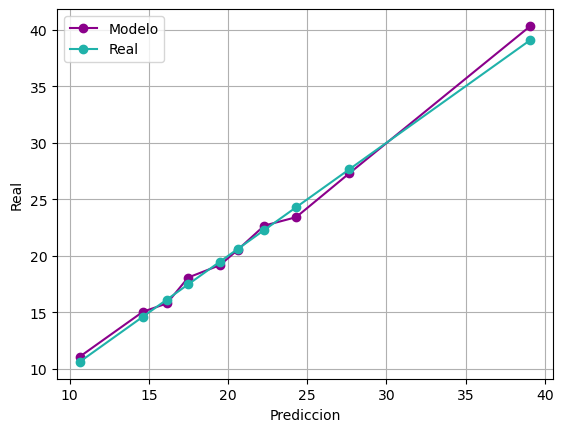

In [8]:
calibracion(predicciones_poly2_nuevo_fe, y_test, bins = 10)

### Análisis:

- El mejor modelo obtenido fue el de **regresión polinomial de grado 2 utilizando feature engineering y sin eliminar ninguna variable**. Este modelo obtuvo un **R2 de 0.9029**, lo cual significa que el modelo explica el 90.29% de la variación de los datos. Este R2 es muy bueno, indicando una buena precisión del modelo al momento de ajustarse a los datos reales. 

## Red Neuronal

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor())
])

params_grid = {
    'nn__hidden_layer_sizes': [(100,50,100), (10,), (100,), (10,10)],
    'nn__activation': ['tanh', 'relu', 'logistic'],
    'nn__alpha': [0.1, 0.01, 0.001]
}

grid_nn = GridSearchCV(estimator=pipeline, param_grid=params_grid, n_jobs=-1, cv=5, scoring='r2')
grid_nn.fit(X_train, y_train)

C:\Users\arant\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('nn', MLPRegressor())]),
             n_jobs=-1,
             param_grid={'nn__activation': ['tanh', 'relu', 'logistic'],
                         'nn__alpha': [0.1, 0.01, 0.001],
                         'nn__hidden_layer_sizes': [(100, 50, 100), (10,),
                                                    (100,), (10, 10)]},
             scoring='r2')

In [10]:
grid_nn.best_params_

{'nn__activation': 'relu',
 'nn__alpha': 0.01,
 'nn__hidden_layer_sizes': (100, 50, 100)}

In [11]:
predictions_nn = grid_nn.best_estimator_.predict(X_test)

r2_score(y_pred=predictions_nn, y_true=y_test)

0.874528545426266

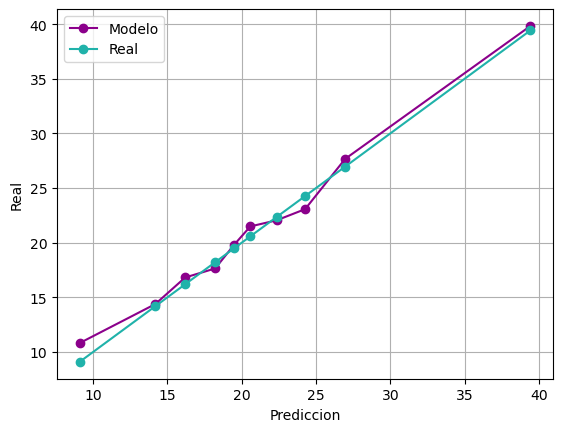

In [12]:
calibracion(predictions_nn, y_test, bins = 10)

### Análisis:

- Tras hacer una red neuronal, se llegó a la conclusión de que la mejor función de activación fue **relu** con un **alpha de 0.001** y **3 capas con 100, 50 y 100 neuronas**. Este modelo obtuvo un **R2 de 0.8745**, lo cual nos indica que el 87.45% de la variación de los datos es explicado con el modelo. Aunque no es un R2 bajo, se ve una clara diferencia entre el modelo de la red neuronal y la regresión polinomial de grado 2 que se hizo anteriormente, ya que este obtuvo un R2 de 90.29%. Esta diferencia también es evidente en las dos gráficas de calibración, ya que, con la red neuronal, se puede ver como el modelo no es tan preciso como el otro. 